In [1]:
from labs.install_deps import require_think_dsp

require_think_dsp()

thinkdsp.py successfully download


Упражнение 4.1
Скачаем несколько файлов природных источников шума, вычислим спектры каждого сигнала.

In [2]:
from thinkdsp import read_wave

wave = read_wave('412308__straget__big-waves-hit-land.wav')
segment = wave.segment(start=1.5, duration=1.0)
segment.make_audio()

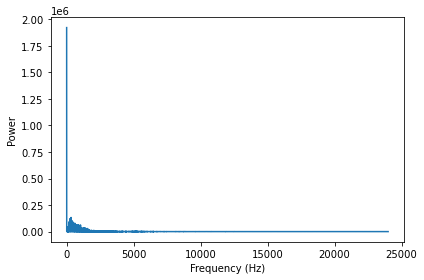

In [3]:
from thinkdsp import decorate

spectrum = segment.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

Амплитуда уменьшается с частотой, поэтому это может быть красный или розовый шум.  Проверим это, посмотрев на спектр мощности в логарифмической шкале.

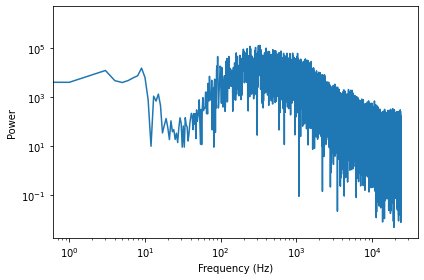

In [4]:
spectrum.plot_power()

loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Здесь мы видим увеличивающуюся, а затем уменьшающуюся мощность.
Чтобы увидеть, как спектр меняется со временем, выберем другой сегмент.

In [5]:
segment2 = wave.segment(start=3.5, duration=1.0)
segment2.make_audio()

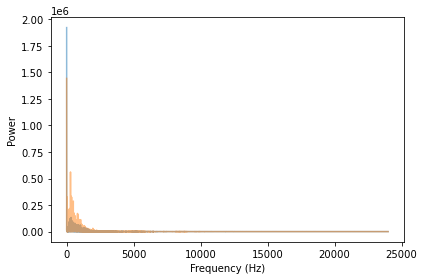

In [6]:
spectrum2 = segment2.make_spectrum()

spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

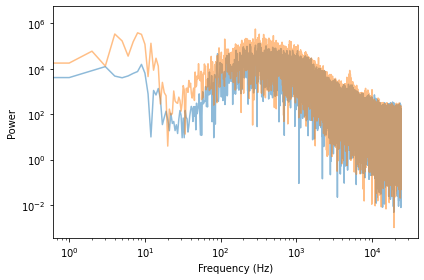

In [7]:
spectrum.plot_power(alpha=0.5)
spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Cтруктура остается почти неизменной с течением времени.
Посмотрим также на спектрограмму.

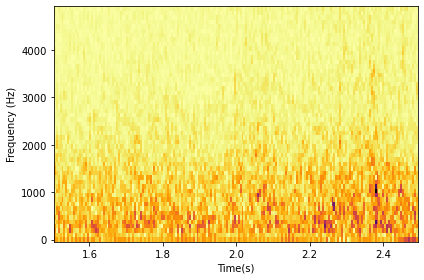

In [8]:
segment.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

В пределах этого сегмента общая амплитуда падает.

Упражнение 4.2
Реализуем метод Бартлетта и используем его для оценки спектра мощности шумового сигнала.

In [9]:
from thinkdsp import Spectrum
import numpy as np

def bartlett_method(wave, seg_length=512, win_flag=True):
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()

    psds = [spectrum.power for spectrum in spectrums]

    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs

    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

bartlett_method создает спектрограмму и извлекает spec_map, происходит вычисление PSD для каждого спектра, затем их суммирование и помещение результатов в Spectrum.

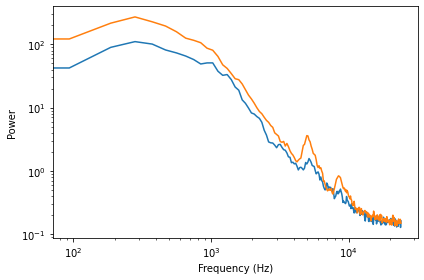

In [10]:
psd = bartlett_method(segment)
psd2 = bartlett_method(segment2)

psd.plot_power()
psd2.plot_power()

decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Здесь видим взаимосвязь между мощностью и частотой. Видна не совсем линейная зависимость, но она остается стабильной для разных сегментов.

Упражнение 4.3
Скачаем в виде CSV-файла исторические данные о ежедневной цене BitCoin. Вычислим спектр цен BitCoin как функцию времени.

In [11]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-2020_price-CoinDesk.csv',
                 parse_dates=[0])
df

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.654990,124.304660,124.751660,122.563490
1,BTC,2013-10-02,125.455000,123.654990,125.758500,123.633830
2,BTC,2013-10-03,108.584830,125.455000,125.665660,83.328330
3,BTC,2013-10-04,118.674660,108.584830,118.675000,107.058160
4,BTC,2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...,...
2354,BTC,2020-03-22,5884.340133,6187.042146,6431.873162,5802.553402
2355,BTC,2020-03-23,6455.454688,5829.352511,6620.858253,5694.198299
2356,BTC,2020-03-24,6784.318011,6455.450650,6863.602196,6406.037439
2357,BTC,2020-03-25,6706.985089,6784.325204,6981.720386,6488.111885


In [12]:
ys = df['Closing Price (USD)']
ts = df.index

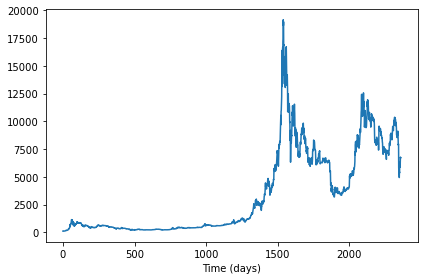

In [13]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)')

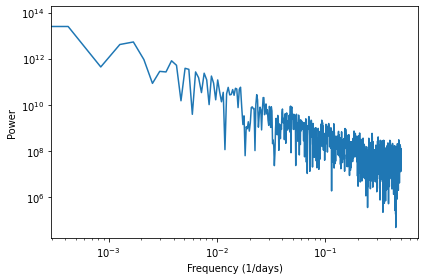

In [14]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (1/days)',
         ylabel='Power',
         **loglog)

In [15]:
spectrum.estimate_slope()[0]

-1.7332540936758956

0-(-2) - шум, находящийся между белым и красным, поэтому можем отнести шум, приведенный выше, к розовому.

Упражнение 4.4
Напишем класс UncorrelatedPoissonNoise, наследующий thinkdsp._Noise и предоставляющий evaluate.

In [16]:
from thinkdsp import Noise

class UncorrelatedPoissonNoise(Noise):
    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Сгенерируем пару секунд UP для малых значений amp (например, 0,001) и послушаем.

In [17]:
amp = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

Звук действительно, как у счетчика Гейгера. Сравним ожидаемое количество частиц и их фактическое количество.

In [18]:
expected = amp * framerate * duration
actual = sum(wave.ys)
print(expected, actual)

10.0 15


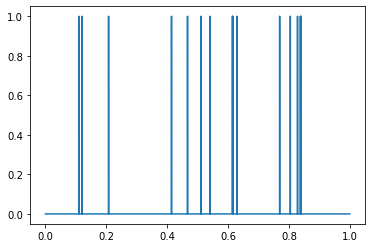

In [19]:
wave.plot()

А также напечатаем спектр мощности в логарифмическом масштабе.

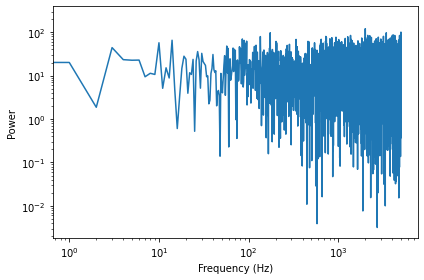

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Похоже на белый шум, и slope близок к нулю.

In [21]:
spectrum.estimate_slope().slope

-0.023688232402720905

При более высокой частоте, это еще больше похоже на белый шум.

In [22]:
amp = 1
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

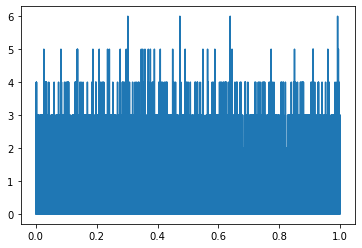

In [23]:
wave.plot()

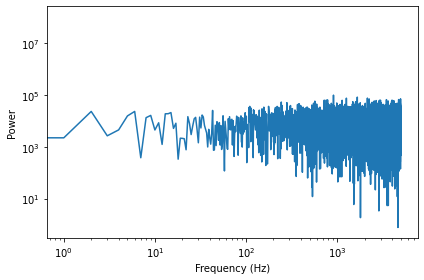

In [24]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Упражнение 4.5
Реализуем алгоритм Voss-McCartney для генерации розового шума.

Основная идея этого алгоритма заключается в суммировании нескольких последовательностей случайных чисел, которые обновляются с разной частотой дискретизации. Первый источник должен обновляться на каждом временном шаге; второй источник - на каждом втором временном шаге, третий источник - на четвертом шаге и так далее.

Эта реализация начинается с массива с одной строкой на каждый временной шаг и одним столбцом для каждого из источников белого шума. Изначально первая строка и первый столбец являются случайными, а остальная часть массива - Nan.

In [25]:
nrows = 100
ncols = 5

array = np.empty((nrows, ncols))
array.fill(np.nan)
array[0, :] = np.random.random(ncols)
array[:, 0] = np.random.random(nrows)
array[0:6]

array([[0.82671136, 0.63917823, 0.86589173, 0.08169346, 0.99184449],
       [0.40015035,        nan,        nan,        nan,        nan],
       [0.90106993,        nan,        nan,        nan,        nan],
       [0.35828896,        nan,        nan,        nan,        nan],
       [0.72148282,        nan,        nan,        nan,        nan],
       [0.86038515,        nan,        nan,        nan,        nan]])

Следующий шаг - выбрать местоположения, в которых меняются случайные источники. Если количество строк равно n, то количество изменений в первом столбце равно n, число во втором столбце в среднем равно n/2, число в третьем столбце в среднем равно n/4 и т.д.

Общее количество изменений в матрице в среднем равно 2n, поскольку n из них находятся в первом столбце, остальные n находятся в остальной части матрицы.

Чтобы разместить оставшиеся n изменений, мы будем генерировать случайные столбцы из геометрического распределения с p=0,5 . Если мы генерируем значение, выходящее за пределы, мы устанавливаем его равным 0.

In [26]:
p = 0.5
n = nrows
cols = np.random.geometric(p, n)
cols[cols >= ncols] = 0
cols

array([4, 1, 0, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       3, 1, 3, 1, 0, 1, 1, 1, 3, 4, 0, 4, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1,
       3, 4, 1, 2, 0, 1, 1, 4, 1, 4, 1, 1, 3, 2, 1, 1, 0, 1, 4, 1, 1, 1,
       1, 2, 3, 1, 1, 1, 1, 1, 3, 4, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2,
       1, 1, 3, 3, 1, 2, 1, 0, 1, 1, 1, 1])

Внутри каждого столбца мы выбираем случайную строку из равномерного распределения.

In [27]:
rows = np.random.randint(nrows, size=n)
rows

array([38, 68,  5, 22, 54, 24,  5, 29, 48, 32, 91, 89, 16, 10, 85, 40, 90,
       58, 32, 58, 77, 69, 30, 16, 30, 55, 71, 53, 91, 63, 80, 47, 65, 52,
       24, 65, 61, 29, 80, 98, 30, 31,  5, 34, 56, 49, 33, 47, 82, 68, 94,
       84, 26, 65, 87, 65, 25, 38, 80, 78, 22, 76, 13, 78, 23, 66,  4, 27,
       30, 49, 36, 80, 91, 14,  7, 31, 47, 36, 45, 92, 68, 74, 31, 85, 38,
       58, 46, 50,  0, 34, 63, 84, 96, 41, 31, 49, 88, 58, 12, 86])

Теперь мы можем поместить случайные значения в каждую из точек изменения.

In [28]:
array[rows, cols] = np.random.random(n)
array[0:6]

array([[0.82671136, 0.22787457, 0.86589173, 0.08169346, 0.99184449],
       [0.40015035,        nan,        nan,        nan,        nan],
       [0.90106993,        nan,        nan,        nan,        nan],
       [0.35828896,        nan,        nan,        nan,        nan],
       [0.72148282, 0.6987169 ,        nan,        nan,        nan],
       [0.37424108, 0.49745673,        nan,        nan,        nan]])

Далее мы хотим выполнить удержание нулевого порядка, чтобы заполнить NaN.

In [29]:
df = pd.DataFrame(array)
df.head()

,0,1,2,3,4
0,0.826711,0.227875,0.865892,0.081693,0.991844
1,0.400150,NaN,NaN,NaN,NaN
2,0.901070,NaN,NaN,NaN,NaN
3,0.358289,NaN,NaN,NaN,NaN
4,0.721483,0.698717,NaN,NaN,NaN


А затем используем fillna вдоль столбцов.

In [30]:
filled = df.fillna(method='ffill', axis=0)
filled.head()

,0,1,2,3,4
0,0.826711,0.227875,0.865892,0.081693,0.991844
1,0.400150,0.227875,0.865892,0.081693,0.991844
2,0.901070,0.227875,0.865892,0.081693,0.991844
3,0.358289,0.227875,0.865892,0.081693,0.991844
4,0.721483,0.698717,0.865892,0.081693,0.991844


Сложим строки.

In [31]:
total = filled.sum(axis=1)
total.head()

0    2.994016
1    2.567455
2    3.068374
3    2.525593
4    3.359629
dtype: float64

Поместим результаты в волну.

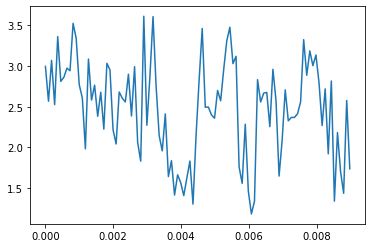

In [32]:
wave = Wave(total.values)
wave.plot()

In [33]:
def voss(nrows, ncols=16):
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)

    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

Протестируем, сгенерируя 11025 тестовых значений.

In [34]:
ys = voss(11025)
ys

array([7.3649028 , 7.73786722, 7.11369332, ..., 6.03862451, 6.65143988,
       6.46436836])

Затем поместим результаты в волну.

In [35]:
wave = Wave(ys)
wave.unbias()
wave.normalize()

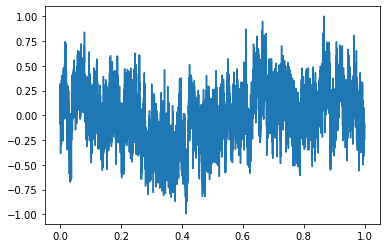

In [36]:
wave.plot()

Характер графика более случайный, чем белый и красный шум.
Послушаем звук.

In [37]:
wave.make_audio()

Рассмотрим спектр мощности.

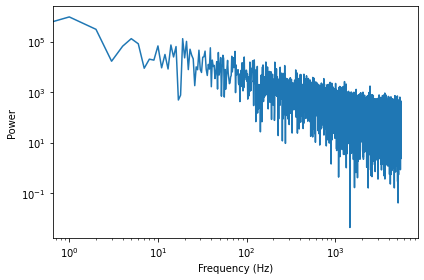

In [38]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

In [39]:
spectrum.estimate_slope().slope

-0.9979843626202138

Slope близок к -1. Можем понять, что сгенерировали розовый шум, поскольку соотношение между мощностью и частотой соответствующее.